In [1]:
from transformers import AutoImageProcessor, ViTModel
import torch
from PIL import Image
import  os
import matplotlib.pyplot as plt

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [2]:
def extract_feature(img_dir, image_processor, model, max_len = 10):
    feats = {}
    files = os.listdir(img_dir)
    
    for f in files[:max_len]:
        f_path = os.path.join(img_dir,f)
        image = Image.open(f_path)
        print("extracting feats of {}".format(f_path))
        inputs = image_processor(image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

            last_hidden_states = outputs.last_hidden_state[:,0]
            # feats.append(last_hidden_states)
            feats[f] = last_hidden_states
        print("success extracting feats of {}".format(f_path))
    return feats

def get_result(ori_feats, back_feats, topn):
    result = {}
    for ori_f in ori_feats.keys():
        dist = {}
        for back_f in back_feats.keys():
            d = torch.nn.functional.cosine_similarity(ori_feats[ori_f], back_feats[back_f])
            # d = torch.ao.ns.fx.utils.compute_cosine_similarity(ori_feats[ori_f], back_feats[back_f])
            dist[back_f] = d
        dist = sorted(dist.items(), key=lambda d:d[1], reverse = True)
        result[ori_f] = dist[:topn]
    return result  

def combine_result(back_result, profile_result):
    for ori in back_result.keys():
        back_result[ori].append(profile_result[ori])
    return back_result

def show_result(back_result, profile_result,  ori_path, back_path, profile_path):
    plt.figure()
    row_num = len(back_result)
    fig, axs = plt.subplots(row_num, 5, figsize=(25, 15))
    i = 1
    for r in back_result.keys():
        image = Image.open(os.path.join(ori_path, r))
        plt.subplot(row_num, 5, i)
        i = i + 1
        plt.imshow(image)
        for rr in back_result[r]:
            image = Image.open(os.path.join(back_path, rr[0]))
            plt.subplot(row_num, 5, i)
            i = i + 1
            plt.imshow(image)
         
        image = Image.open(os.path.join(profile_path, profile_result[r][0][0]))
        plt.subplot(row_num, 5, i)
        i = i + 1
        plt.imshow(image)

In [3]:
ori_path = "./测试2/原图_small"
back_path="./测试2/场景图/正面"
profile_path="./测试2/场景图/侧面"

In [4]:
ori_feats = extract_feature(ori_path, image_processor, model, max_len = 3)

extracting feats of ./测试2/原图_small\1.png
success extracting feats of ./测试2/原图_small\1.png
extracting feats of ./测试2/原图_small\2.jpg
success extracting feats of ./测试2/原图_small\2.jpg
extracting feats of ./测试2/原图_small\3.png
success extracting feats of ./测试2/原图_small\3.png


In [5]:
back_feats = extract_feature(back_path, image_processor, model, max_len = 6)

extracting feats of ./测试2/场景图/正面\1.jpg
success extracting feats of ./测试2/场景图/正面\1.jpg
extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (14).jpg
success extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (14).jpg
extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (2).jpg
success extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (2).jpg
extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (20).jpg
success extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (20).jpg
extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (22).jpg
success extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (22).jpg
extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (26).jpg
success extracting feats of ./测试2/场景图/正面\客厅装饰画空白样机 (26).jpg


In [6]:
profile_feats = extract_feature(profile_path, image_processor, model, max_len = 3)

extracting feats of ./测试2/场景图/侧面\142 (42).jpg
success extracting feats of ./测试2/场景图/侧面\142 (42).jpg
extracting feats of ./测试2/场景图/侧面\1728 (235).jpg
success extracting feats of ./测试2/场景图/侧面\1728 (235).jpg
extracting feats of ./测试2/场景图/侧面\24527 (36).jpg
success extracting feats of ./测试2/场景图/侧面\24527 (36).jpg


<Figure size 640x480 with 0 Axes>

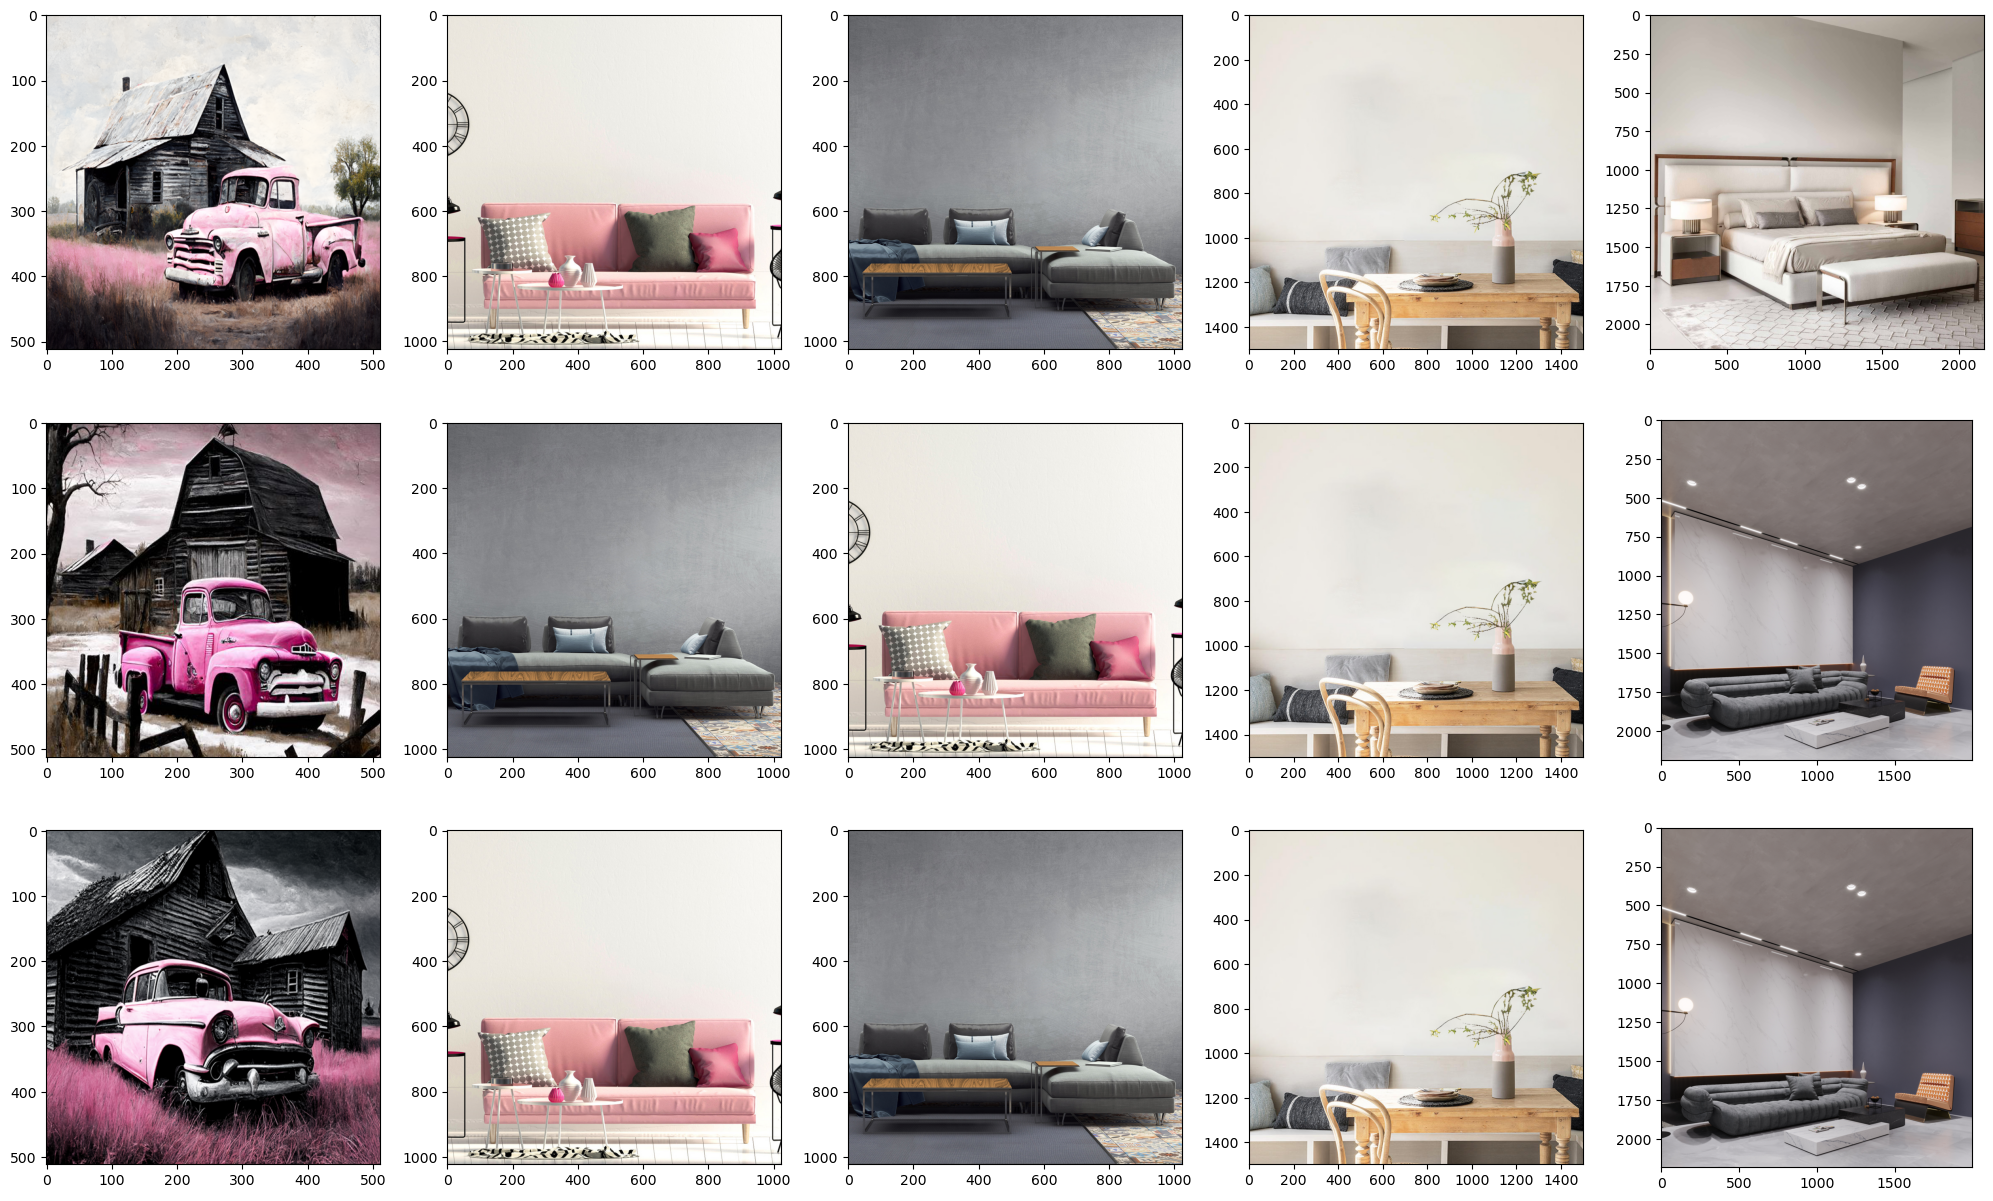

In [7]:
back_res = get_result(ori_feats, back_feats, 3)
profile_res = get_result(ori_feats, profile_feats, 1)

show_result(back_res, profile_res, ori_path, back_path, profile_path)

In [8]:
import pickle
with open("./ori_feats", 'wb') as f:
    pickle.dump(ori_feats, f)

In [11]:
with open("./ori_feats", 'rb') as f:
    data = pickle.load(f)